<a href="https://colab.research.google.com/github/davetew/Zero-Carbon-Aviation/blob/master/Zero_Carbon_Aviation_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-Carbon Aircraft Propulsion and Energy Storage System Options
This notebook contains an assessment of the viability of several zero-carbon commerical aircraft combined energy storage and propulsion system options.

## Energy Storage
The energy storage options to be considered include--
1.   Batteries \\
    a.  [Lithium Ion](https://en.wikipedia.org/wiki/Lithium-ion_battery) \\
    b.  [Lithium Air](https://en.wikipedia.org/wiki/Lithium–air_battery)
    
2.   Fuels \\
    a.  Bio-Kerosene \\
    b.  Ammonia \\
    c.  Hydrogen
    
3.  Nuclear \\
    a.  Thorium-232 \\
    b.  TBD

## Propulsion System
In this context, the propulsion system consists of the chemical/nuclear to shaft power energy conversion system and the propulsor that converts the shaft power into aircraft thrust.

The chemical/nuclear to shaft power propulsion system options that will be considered include--
1.  Open Brayton cycle gas turbines,
2.  Closed Brayton cycles (e.g. $sCO_{2}$ cycles),
3.  Fuel cells with electric motors,
4.  Batteries with electric motors, and
5.  Hybrid cycles using the above technologies that leverage both fuel and battery energy storage systems.

The propulsor options that will be considered include--
1.  Ducted fans, and
2.  Unducted fans.

In [0]:
"""Import the standard modules"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import requests
from io import BytesIO

from IPython.display import Markdown

In [2]:
"""Install, import, and configure 'pint' -- a physical quantity manipulation package"""
!pip install pint

import pint

    100% |████████████████████████████████| 143kB 6.7MB/s 


In [0]:
# Save default unit registry in ureg & Quantity in Q_
ureg = pint.UnitRegistry()
Q_ = ureg.Quantity

# Define a currency dimension with usd (US dollar) as the base unit
ureg.define('usd = [currency]')

In [9]:
# %%capture cantera
# Install Cantera & import module
!apt-add-repository -y ppa:speth/cantera
!apt-get install cantera-python3

import cantera as ct

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/speth/cantera/ubuntu bionic InRelease
Reading package lists... Done
Reading package lists... Done
Bui

In [0]:
"""Define fuel property classes"""

class Fuel:
    """Fuel specification class"""
    def __init__(self, phase_definition=None, 
                 specific_cost=None,
                 liquid_density=None):
      
        self.phase_definition = phase_definition
        self.phase = ct.Solution(source=phase_definition)
        self.specific_cost = specific_cost
        self.liquid_density = liquid_density
    
    @property
    def cost_liquid_volume_specific(self, unit_string='usd/liter'):
      """Calculate and return the liquid volume specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specfic cost is already liquid volume specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specific cost is mass-specific - calculate & return volumetric cost
        return (self.specific_cost * self.liquid_density).to(ureg[unit_string])
 
    @property
    def cost_mass_specific(self, unit_string='usd/kg'):
      """Calculate and return the mass specific cost"""
      if self.specific_cost.to_base_units().units == ureg['usd/kg']:
        
        # Input specfic cost is already mass specific - convert to specified units
        return self.specific_cost.to(ureg[unit_string])
      
      elif self.specific_cost.to_base_units().units == ureg['usd/meters**3']:
        
        # Input specific cost is volume-specific - calculate & return mass-specific cost
        return (self.specific_cost / self.liquid_density).to(ureg[unit_string])
        
    @property
    def lower_heating_value(self):
      """Calculate and return the lower heating value"""
      
      # Specify the reactant state
      reactants = ct.Solution(source=self.phase_definition)
      reactants.TP = 298, ct.one_atm
      reactants.set_equivalence_ratio(1.0, self.phase.name, 'O2:1.0')
      
      # Calculate the fuel mass fraction
      Y_fuel = reactants[self.phase.name].Y[0]
      
      # Complete combustion products
      Y_products = {'CO2': reactants.elemental_mole_fraction('C'),
                    'H2O': 0.5 * reactants.elemental_mole_fraction('H'),
                    'N2': 0.5 * reactants.elemental_mole_fraction('N')}
      
      # Calculate the product enthalpy at 298 K, 1 atm
      products = ct.Solution(source=self.phase_definition)
      products.TPX = 298, ct.one_atm, Y_products
      
      return Q_( (reactants.enthalpy_mass - products.enthalpy_mass) / Y_fuel,
                ureg['J/kg'] )
    
    @property
    def cost_energy_specific(self, unit_string='usd/kWh'):
        """Calculate the energy-specific cost of fuel on a lower-heating-value basis."""
        return (self.cost_mass_specific / self.lower_heating_value).to(ureg[unit_string])

      
class Methane(Fuel):
    """Methane per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.4, ureg['usd/liter'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='CH4',
                        elements='C O H N',
                        species='nasa_gas:CH4 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(423, ureg['kg/meter**3']))
      
class JetA(Fuel):
    """Jet Fuel per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(1.4, ureg['usd/liter'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='Jet-A(g)',
                        elements='C O H N',
                        species='nasa_gas:Jet-A(g) H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(804, ureg['kg/meter**3']))

class Ammonia(Fuel):
    """Ammonia per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(500, ureg['usd/tonne'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='NH3',
                        elements='C O H N',
                        species='nasa_gas:NH3 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(682, ureg['kg/meter**3']))    

class Hydrogen(Fuel):
    """Ammonia per the NASA CEA Code Specification"""
    def __init__(self, specific_cost=Q_(4, ureg['usd/kg'])):
      
      # Initialize the superclass using the below Cantera phase definition
      Fuel.__init__(self, phase_definition=
                    '''ideal_gas(name='H2',
                        elements='C O H N',
                        species='nasa_gas:H2 H2O CO2 O2 N2',
                        options=['skip_undeclared_elements'],
                        initial_state=state(temperature=300, pressure=101325))''', 
                    specific_cost=specific_cost,
                    liquid_density=Q_(71, ureg['kg/meter**3'])) 

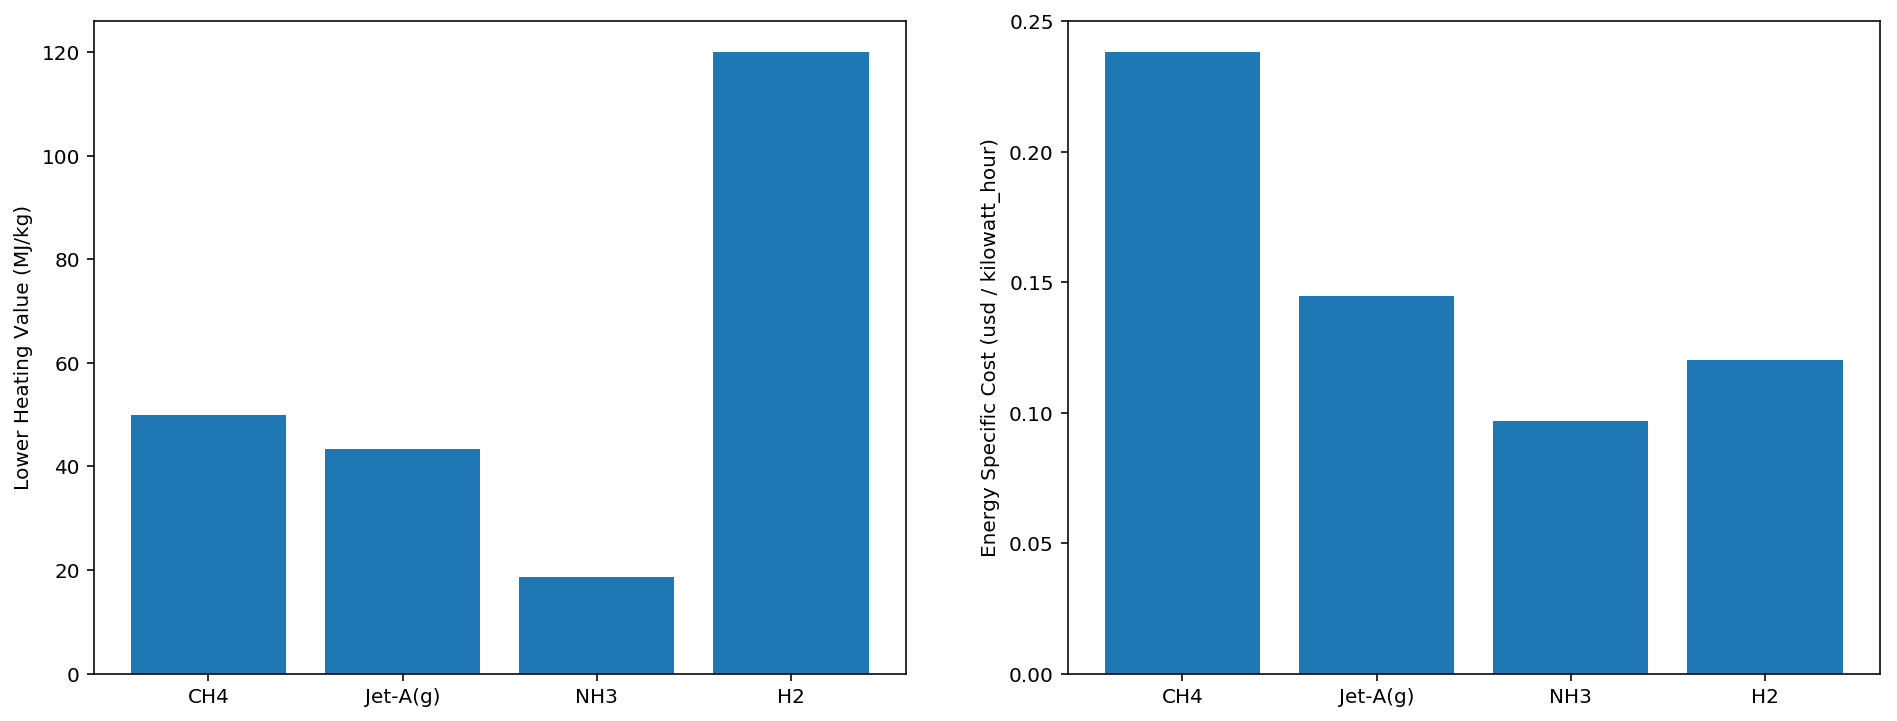

In [13]:
ch4 = Methane()

bioK = JetA()

nh3 = Ammonia()

h2 = Hydrogen()

fuels = [ch4, bioK, nh3, h2]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
ind = np.arange(1,len(fuels)+1)

ax1.bar(ind, [fuel.lower_heating_value.to('MJ/kg').magnitude for fuel in fuels])
ax1.set_xticks(ind)
ax1.set_xticklabels([fuel.phase.name for fuel in fuels])
ax1.set_ylabel('Lower Heating Value (MJ/kg)')

ax2.bar(ind, [fuel.cost_energy_specific.magnitude for fuel in fuels])
ax2.set_xticks(ind)
ax2.set_xticklabels([fuel.phase.name for fuel in fuels])
ax2.set_ylabel(f'Energy Specific Cost ({fuels[0].cost_energy_specific.units})')

plt.show()

## Aircraft Performance Data

Performance data for 'representative' aircraft from four different aircraft classes are stored in the JSON-format-like `AircraftData` dictionary.  These aircraft include the following commercial aircraft--
1.  A turboprop [Bomardier Dash 8-Q400](https://en.wikipedia.org/wiki/Bombardier_Dash_8),
2.  A regional jet [Airbus A220-300](https://www.airbus.com/aircraft/passenger-aircraft/a220-family/a220-300.html),
3.  A single aisle [Boeing 737 MAX 8](https://en.wikipedia.org/wiki/Boeing_737_MAX), and
4.  A twin aisle [Boeing 777X](https://en.wikipedia.org/wiki/Boeing_777X).

The data provided include the following types of information--
1. Weight,
2. Wing geometry,
3. Cruise speed and/or Mach number,
3. Payload (fuel & passengers),
4. Cost,
5. Engines.

More detailed information on these characteristics is provided below.

### Weight
When available, four different weights are recorded within the dictionary.  These weight include--
1. Maximum Gross Take-Off Weight ($MTOW$),
2. Maximum Zero Fuel Weight ($MZFW$),
3. Operating Empty Weight ($OEW$), and
4. Maximum Landing Weight ($MLW$),

$MTOW$ is the maximum authorized weight at brake release.  $TOW$ is the actual take-off weight, which may be calculated from the below expression.

$$TOW = OEW + PL + FW$$

$$TOW \leq MTOW$$

$PL$ is the payload weight, and $FW$ is the fuel weight.  $OEW$ is the operating empty weight of the aircraft; it includes the weight of the aircraft structure ($SW$) and the weight of the propulsion system ($PW$)--

$$OEW = SW + PW$$

$MZFW$ is the maximum aircraft weight before fuel and other consumable propulsion system agents are loaded onto the aircraft.

$$MZFW = OEW + PL_{max}$$

$PL_{max}$ is the maximum payload.

In this context, the payload weight ($PL$) includes passengers, luggage, cargo, crew, food, beverages and related supplies.  Also, the fuel weight ($FW$) is assumed to include all propulsion-related consumables (e.g. fuel, oil).

For purposes of the propulsion and energy storage system analyses anticipated in this notebook, the aircraft considered will be assumed to take-off at their maximum take-off weight ($MTOW$) with their maximum payloads ($PL_{max}$). 

\begin{align}
MTOW & = OEW + PL_{max} + FW \\
& = SW + PW + PL_{max} + FW \\
& = SW + PL_{max} + PW + FW
\end{align}

The maximum payload is calculated from the available $MZFW$ and $OEW$ data--

$$PL_{max} = MZFW - OEW$$

Also, the fuel weight will be calculated from the available $MTOW$ and $OEW$ and the calculated $PL_{max}$.

$$FW = MTOW - OEW - PL_{max}$$

The propulsion system weight ($PW$) will be estimated from the engine data contained within the dictionary.  However, this weight is likely an underestimate of the weight as it is likely not inclusive of the engine nacelle and pylon.


In [0]:
def clean_data(dirty_df):
  """Clean up dataframe read from csv file whose first column was used as the index, and
  the individual indicies contained the quantity name and the units in parenthesis.
  
  The clean up process involves first converting the numeric cells from strings 
  and then converting the floats to "pint" physical quantities using the units provided."""
  
  def convert_numbers_to_floats(df):
    """Convert numeric values in the input data frame to floats"""
    
    def is_float(input):
      """Check to see if an input string contains a float"""
      try:
        num = float(input)
      except ValueError:
        return False
      return True
    
    return df.applymap(lambda x: float(x.replace(",","")) 
                       if isinstance(x, str) and is_float(x.replace(",",""))
                       else x)
  
  def get_units_and_create_new_indices(df):
    """Get physical units from portions of index strings that are between ( ) and
    remove the unit specification from the index strings to create simpler indices"""
    
    unit_strings = []; new_indices = []
    for index, row in df.iterrows():
  
      if index.find("(") == -1:
        unit_strings.append("")
        new_indices.append(index)
      else:    
        unit_strings.append(index[index.find("(")+1:index.find(")")])
        new_indices.append(index[0:index.find("(")-1])
        
    return unit_strings, new_indices
  
  # Convert numbers to floats
  clean_df = convert_numbers_to_floats(dirty_df)
  
  # Get units & new indices
  unit_strings, new_indices = get_units_and_create_new_indices(clean_df)
  
  # Switch to new indices
  # clean_df.reindex(new_indices)
  clean_df['Parameters'] = new_indices
  clean_df.set_index('Parameters', inplace=True)
  
  # Add units (i.e. create pint Quantities) for numeric values with physical units
  for unit_string, parameter in zip(unit_strings, clean_df.index.values.tolist()):
    for column in clean_df.columns:
      if isinstance(clean_df.loc[parameter, column], float) and not( unit_string == ""):
        clean_df.loc[parameter, column] = clean_df.loc[parameter, column] * ureg(unit_string)
  
  return clean_df

In [16]:
"""Load aircraft data"""

# Get data from Google spread sheet on Dave's G Drive
rawACData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vSA_H7NEvMSQTltN4FRqKaJ-8uWw_bDHwP2WarH4PzRh8Qm3IOajMyOMxhZ1hzv9Ui-tXKjMt9KhvuY/pub?gid=0&single=true&output=csv')

# Save the data in a pandas data frame
AircraftData = clean_data(pd.read_csv(BytesIO(rawACData.content), index_col=0, thousands=r","))

# Get list of aircraft represented in data frame
Aircraft = AircraftData.columns

# Calculate the max payload and fuel weights for the varoious aircraft and append them to the dataframe
AircraftData.loc['Max Payload Weight'] = AircraftData.loc['Max Zero Fuel Weight'] - AircraftData.loc['Operating Empty Weight']

AircraftData.loc['Fuel Weight'] = ( AircraftData.loc['Max Take Off Weight'] - 
                                    AircraftData.loc['Operating Empty Weight'] - 
                                    AircraftData.loc['Max Payload Weight'] )

display(AircraftData)

/usr/local/lib/python3.6/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


,Dash-8-Q400,A220-300,737 MAX 8,777-9X
Parameters,,,,
Max Take Off Weight,29260.0 kilogram,67600.0 kilogram,82191.0 kilogram,351500.0 kilogram
Max Landing Weight,28010.0 kilogram,58700.0 kilogram,69309.0 kilogram,266000.0 kilogram
Max Zero Fuel Weight,25850.0 kilogram,55800.0 kilogram,65952.0 kilogram,255000.0 kilogram
Operating Empty Weight,17110.0 kilogram,37081.0 kilogram,45070.0 kilogram,181400.0 kilogram
Cruise Mach,NaN,0.82,0.79,NaN
Cruise Speed,667.0 kilometer / hour,829.0 kilometer / hour,839.0 kilometer / hour,900.0 kilometer / hour
Wing Area,63.1 meter ** 2,112.3 meter ** 2,127.0 meter ** 2,466.8 meter ** 2
Wing Span,28.4 meter,35.1 meter,35.92 meter,71.8 meter
Fuel Capacity,6530.0 liter,21918.0 liter,25817.0 liter,198000.0 liter


In [17]:
"""Load Engine Data"""
rawEngData = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ5-u7udgzqZoPJy4Ao6RTlmFTSbg3_71hMCk9AkI_x1yTCiGVxs4ltPtdKUrMduxsepPMq6e0QzaCz/pub?gid=0&single=true&output=csv')
EngineData = clean_data(pd.read_csv(BytesIO(rawEngData.content), index_col=0))
display(EngineData)

/usr/local/lib/python3.6/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


,PW150A,PW1500G,CFM LEAP 1B,GE9X-105B1A
Parameters,,,,
Type,Turboprop,Turbofan,Turbofan,Turbofan
OPR,NaN,NaN,40,61
BPR,NaN,12,9,10
TSFC,nan gram / kilonewton / second,nan gram / kilonewton / second,12.0 gram / kilonewton / second,nan gram / kilonewton / second
Fan Diameter,nan meter,1.85 meter,1.76 meter,3.39 meter
Weight,716.9 kilogram,2177.0 kilogram,2780.0 kilogram,18182.0 kilogram
Cost,nan megausd,12.0 megausd,14.5 megausd,nan megausd
Thrust Take Off,3.75 kilonewton,108.54 kilonewton,130.41 kilonewton,470.0 kilonewton
Thrust Max Continuous,3.75 kilonewton,nan kilonewton,127.62 kilonewton,nan kilonewton


/usr/local/lib/python3.6/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


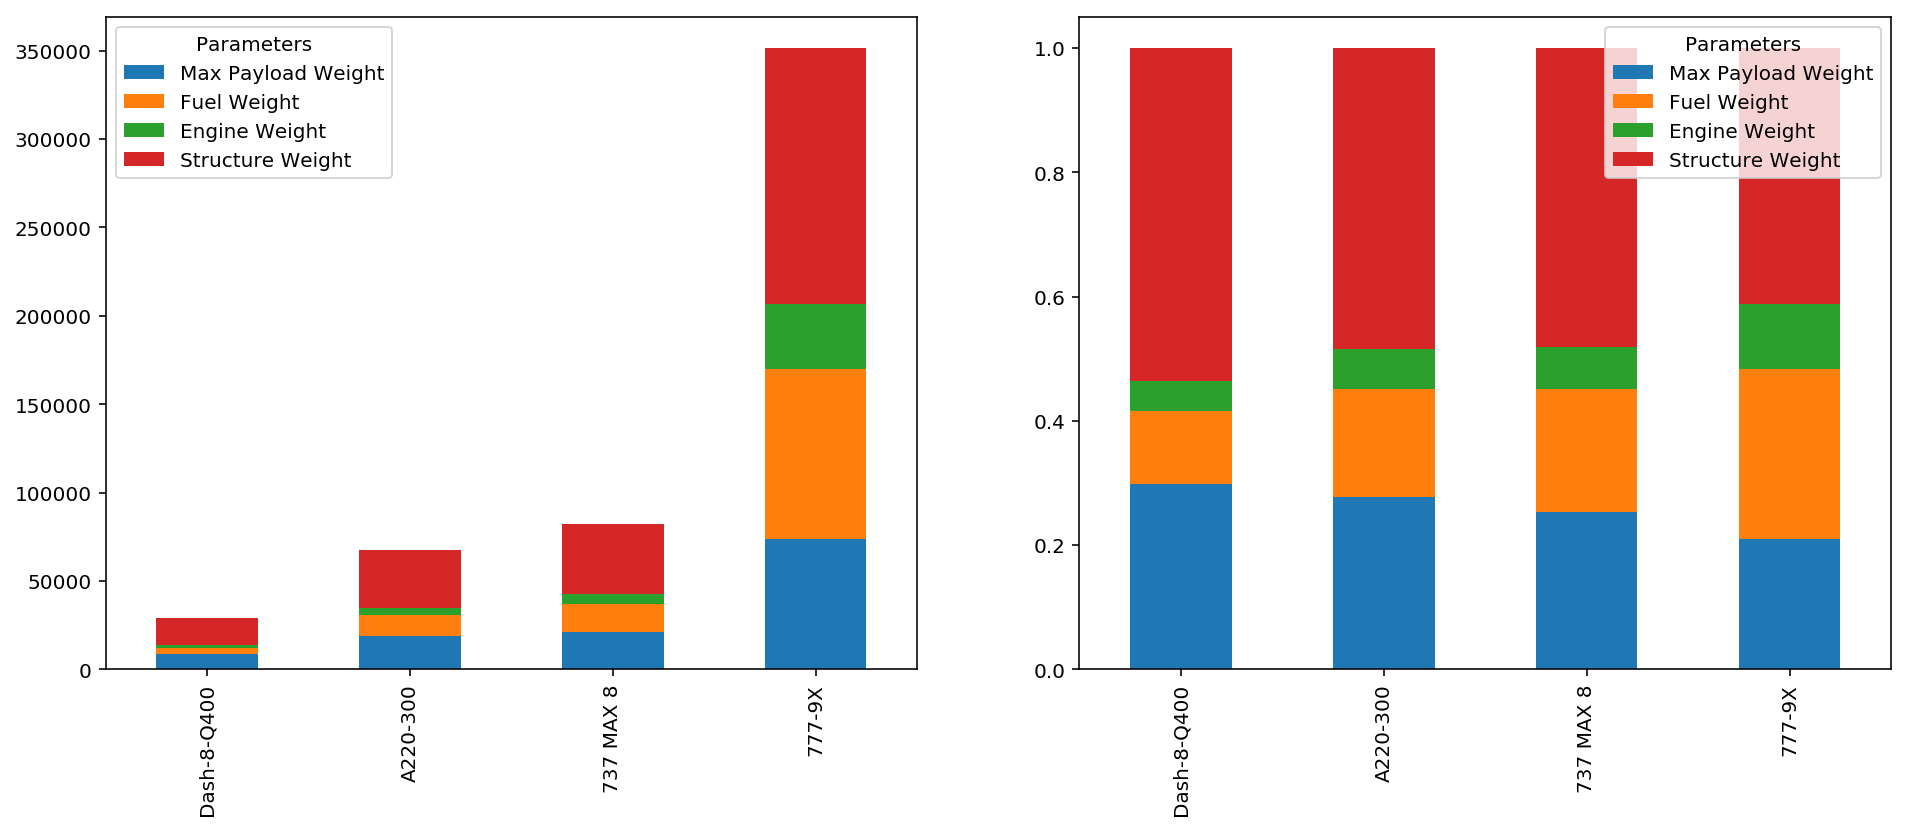

In [18]:
# Calculate the total propulsion system (i.e. engine) weight for the aircraft and append it to the aircraft dataframe
for aircraft in Aircraft:
  AircraftData.loc['Engine Weight', aircraft] = ( EngineData.loc['Weight', AircraftData.loc['Engine Type', aircraft]] * 
                                                 AircraftData.loc['Engine Number', aircraft] )

# Calculate the weight of the aircraft structure w/o the propulsion system
AircraftData.loc['Structure Weight'] = ( AircraftData.loc['Operating Empty Weight'] - 
                                         AircraftData.loc['Engine Weight'] )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Stacked bar chart with aircraft weight breakdown
WeightSummary = AircraftData.loc['Max Payload Weight':'Structure Weight']
WeightSummary.transpose().applymap(lambda x: x.magnitude).plot.bar(stacked=True, ax=axes[0])

# Normalized Weight Summary 
NormWeightSummary = AircraftData.loc['Max Payload Weight':'Structure Weight'] / AircraftData.loc['Max Take Off Weight']
NormWeightSummary.transpose().applymap(lambda x: x.magnitude).plot.bar(stacked=True, ax=axes[1])

## Propulsion System Performance
The thrust power produced by an aircraft propulsion system is given by

$$ P_{thrust} = TV_{flight}$$

$T$ is the thrust, and $V_{flight}$ is the aircraft flight velocity.

Primary propulsors considered in this analysis will be either ducted fans or propellers (i.e. unducted fans).  However, the secondary thrust contributions of turbofan and turboprop cores will also be considered.

### Propulsion System Efficiency
The energy efficiency of the primary propulsors is given by

$$\eta_{propulsor} = \frac{TV_{flight}}{P_{shaft}}$$

$P_{shaft}$ is the input mechanical shaft power required to spin the propulsor.

In this analysis, multiple energy storage options will be considered--including batteries and fuels.  Furthermore, multiple energy conversion approches will be investigated.  These approaches will include--
1.  single conversion devices that directly convert stored chemical energy (e.g. fuel) into shaft power and 
2.  dual chained conversion devices where one devices converts stored chemical energy (e.g. fuel, battery) into electric power and a second device (e.g. an electric motor) converts the electric power into shaft power.

In the single conversion device scenario, the shaft power produced by the device may be expressed as

$$P_{shaft} = \eta_{thermochemical}P_{chemical}$$

$\eta_{thermal}$ is the thermo-chemical conversion efficiency.  For example, if the conversion device is a gas turbine, $\eta_{thermochemical}$ is the thermal efficiency of the gas generator.  

In the dual conversion device scenario, the shaft power produced by the device chain may be expressed as 

$$P_{shaft} = \frac{P_{shaft}}{P_{electric}}  \frac{P_{electric}}{P_{chemical}}P_{chemical} = \eta_{motor}\eta_{electrochemical}P_{chemical}$$

The propulsor and chemical to shaft power conversion efficiencies may be combined to yield the two following expressions for the overall efficiency of the propulsion system.

For the single conversion device (i.e. chemical --> mechanical)  scenario--

$$\eta_{overall} = \frac{TV_{flight}}{P_{chemical}} = \eta_{propulsor}\eta_{themochemical}$$

For the dual conversion device (i.e. chemical --> electrical --> mechanical) scenario--

$$\eta_{overall} = \eta_{propulsor}\eta_{motor}\eta_{electrochemical}$$

### Propulsion System Mass
The overall mass of a propulsion system is given by the two following expressions.

For the single conversion device scenario--

$$M_{overall} = M_{propulsor} + M_{thermochemical}$$

For the dual conversion device scenario--

$$M_{overall} = M_{propulsor} + M_{motor} + M_{electrochemical}$$

The power specific mass of a propulsion system is given by the following two expressions.

For the single conversion device scenario--

\begin{align}
\frac{M_{overall}}{P_{thrust}} & = \frac{M_{propulsor}}{P_{thrust}} + \frac{M_{thermochemical}}{P_{shaft}}\frac{P_{shaft}}{P_{thrust}} \\
& = \mu_{propulsor}+\frac{\mu_{thermochemical}}{\eta_{propulsor}}
\end{align}

For the dual conversion device scenario--

\begin{align}
\frac{M_{overall}}{P_{thrust}} & = \mu_{propulsor}+ \frac{M_{motor}}{P_{shaft}} \frac{P_{shaft}}{P_{thrust}} + \frac{M_{electrochemical}}{P_{electric}} \frac{P_{electric}}{P_{thrust}} \\
& = \mu_{propulsor} + \frac{\mu_{motor}}{\eta_{propulsor}} + \frac{\mu_{electrochemical}}{\eta_{motor}\eta_{propulsor}} \\
& = \mu_{propulsor} + \frac{1}{\eta_{propulsor}}\left(\mu_{motor} + \frac{\mu_{electrochemical}}{\eta_{motor}}\right)
\end{align}


In [19]:
"""Copy propulsion system schematics from github site"""
!wget https://github.com/davetew/Zero-Carbon-Aviation/blob/master/Gas-Turbine.png -P /usr/local/share/jupyter/nbextensions/google.colab
!ls /usr/local/share/jupyter/nbextensions/google.colab

!wget https://github.com/davetew/Zero-Carbon-Aviation/blob/master/Gas-Turbine.png -P .
!ls 

--2019-04-22 22:34:52--  https://github.com/davetew/Zero-Carbon-Aviation/blob/master/Gas-Turbine.png
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/usr/local/share/jupyter/nbextensions/google.colab/Gas-Turbine.png’

Gas-Turbine.png         [ <=>                ]  54.48K  --.-KB/s    in 0.02s   

2019-04-22 22:34:52 (2.14 MB/s) - ‘/usr/local/share/jupyter/nbextensions/google.colab/Gas-Turbine.png’ saved [55792]

colabwidgets  files.js	Gas-Turbine.png  tabbar.css  tabbar_main.min.js
--2019-04-22 22:34:54--  https://github.com/davetew/Zero-Carbon-Aviation/blob/master/Gas-Turbine.png
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to

In [20]:
from IPython.display import Image, display
display(Image('Gas-Turbine.png'))

## Thrust Specific Fuel Consumption
The thrust specific fuel consumption (TSFC) of a thrust producing aircraft engine is given by

$$ TSFC = \frac{\dot{m}_{fuel}}{T} $$

$\dot{m}_{fuel}$ is the mass flow rate of fuel, and $T$ is the engine thrust.  Typical metric units for $TSFC$ are $g / kN s$.

The specific impulse of that same engine is given by

$$ I_{sp} = \frac{T}{\dot{m}_{fuel} g}  = \frac{1}{TSFC*g} $$

$g$ is the gravitional acceleration (e.g. $9.8  m/s^2$). The $I_{sp}$ is typically expressed in units of seconds.

For the above-specified units for $TSFC$, $I_{sp}$ in seconds may be calculated from the $TSFC$ per the below expression

$$ I_{sp} = \frac{1e6}{TSFC*g} $$

## Aircraft Range Model 
The range of an aircraft may be estimated from the Breguet range equation, which is derived below for aircraft that
1. lose mass via the consumption of fuel,
2. maintain a constant mass, and
3. aircraft that gain mass through the accumulation of oxygen in a metal air battery.

In each of these analyses, only the steady level portion of the flight will be considered.  In this portion of the flight,

\begin{align}
L & = W \\
T & = D
\end{align}

Hence, the required aircraft thrust may be expressed as a function of the weight and the aircraft lift to drag ratio.

$$ W = L = D\frac{L}{D} = T\frac{L}{D} $$

### Fuel-Consuming Aircraft
The rate of change of mass of a fuel-consuming aircraft during flight is given by

$$ -\frac{dW}{dt} = g\dot{m}_{f} = \frac{T}{I_{sp}}. $$

This expression may be inserted into the above differential equation for rate of change of aircraft mass during flight.

$$ \frac{dW}{dt} = -\frac{W}{(L/D)I_{sp}} $$ 

$$ \frac{dW}{W} = -\frac{dt}{(L/D)I_{sp}} $$

Both sides of the above expression may be integrated to yield and expression that relates the aircraft weight and flight duration.

$$ \ln\frac{W}{W_0} = - \frac{t}{(L/D)I_{sp}} $$

$$ t_{f} = \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

Knowing the cruise/flight velocity ($V$), the range ($R$) may be calculated.

$$ R = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_f} $$

$$ W_{f} = W_{0} - W_{fuel} $$

$$ R_{fc} = t_{f}V = V \frac{L}{D}I_{sp}\ln\frac{W_0}{W_{0} - W_{fuel}} $$

The above expression for the range of a fuel consuming aircraft may be rewritten in terms of the overall propulsion system efficiency ($\eta_{overall}$) and the specific energy of the energy storage media ($\epsilon_{fuel}$).

$$ R_{fc} = \ln \frac{1}{1-\frac{M_{fuel}}{M_{0}}}\frac{1}{g}\frac{L}{D}\eta_{overall}\epsilon_{fuel} $$

Reference: [MIT Unified Notes](http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node98.html)

### Constant Mass Aircraft
The maximum duration of a flight of a constant mass aircraft is given by

$$t_{f} = \frac{E_{chemical}}{P_{chemical}}$$

$E_{chemical}$ is the total stored energy at the begining of the flight, and $P_{chemical}$ is the rate at which that energy is consumed during the flight.

Using the definition of the overall propulsion system efficiency, $t_{f}$ may be expressed as

$$t_{f} = \frac{E_{chemical}}{TV_{flight}}\eta_{overall}$$

The range is equal to the time of flight times the flight velocity--

$$R_{cm}=t_{f}V_{flight}$$

For steady level flight, the required thrust may be expressed in terms of the aircraft weight and lift to drag ratio.

$$T=D=\frac{W_{0}}{L/D}$$

In sum, the range may be expressed as a function of the initial stored chemical energy, the aircraft weight, the aircraft lift to drag ratio and the overall propulsion system efficiency.

$$R_{cm}=\frac{E_{chemical}}{W_{0}}\frac{L}{D}\eta_{overall}$$


The inital stored chemical energy ($E_{chemical}$) may be expressed in terms of the energy specific mass of the storage media and its mass.

\begin{align}
E_{chemical} & = M_{chemcal}\frac{E_{chemical}}{M_{chemical}} \\
& = M_{chemical} \epsilon_{chemical} 
\end{align}

$\epsilon_{chemical}$ is the mass-specific energy (e.g. $\frac{Wh}{kg}$) of the storage media.

Consequently, the range of a constant mass aircraft mass be expressed as

$$R_{cm}=\frac{M_{chemical}}{M_{0}}\frac{1}{g}\frac{L}{D}\eta_{overall}\epsilon_{chemical}$$

### Oxygen-Accumulating Aircraft
The rate of change of mass of an oxygen-accumulating aircraft during flight is given by 

$$ \frac{dW}{dt} = g\dot{m}_{O_{2}} = \frac{T}{I'_{sp}}. $$

$$ I'_{sp} = \frac{T}{\dot{m}_{O_{2}}} $$

In steady level flight,

$$ \frac{dW}{W} = \frac{dt}{(L/D)I'_{sp}} $$

Integrating both sides,

$$ \ln\frac{W}{W_0} = \frac{t}{(L/D)I'_{sp}} $$

$$ t_{f} = \frac{L}{D}I'_{sp}\ln\frac{W_f}{W_0} $$

$$ W_{f} = W_{0} + W_{oxygen} $$

$$ R_{oa} = t_{f}V = V \frac{L}{D}I'_{sp}\ln\frac{W_{0} + W_{oxygen}}{W_{0}} $$

The above expression for the range of an oxygen accumulating aircraft may be written in terms of the overall propulsion system efficiency ($\eta_{overall}$) and the mass specific energy ($\epsilon_{chemical}$) of the energy storage media.

$$ R_{oa} = \ln \left(1 + \frac{M_{ox}}{M_{0}} \right) \frac{1}{g} \frac{TV}{\dot{m}_{O_{2}}} $$

For a Lithium-Air battery,

$$ 2Li + O_{2} \rightarrow Li_{2}O_{2}$$

Hence,

\begin{align}
\frac{\dot{n}_{O_{2}}}{\dot{n}_{Li}} &= \frac{1}{2} \\
\frac{\dot{m}_{O_{2}}}{\dot{m}_{Li}} & = \frac{\dot{n}_{O_{2}}}{\dot{n}_{Li}} \frac{\bar{m}_{O_{2}}}{\bar{m}_{Li}} \\
& = \frac{1}{2} \frac{\bar{m}_{O_{2}}}{\bar{m}_{Li}} = \frac{1}{2} \frac{32}{7}
\end{align}

Thus,

$$ \dot{m}_{O_{2}} =\frac{1}{2} \frac{32}{7} \dot{m}_{Li} = 2.3 \dot{m}_{Li} \equiv \beta \dot{m}_{Li} $$

Hence, the range expression may be written as 

\begin{align}
R_{oa} & = \ln \left(1 + \frac{M_{ox}}{M_{0}} \right) \frac{1}{g} \frac{TV}{\beta\dot{m}_{Li}\epsilon_{chemical}} \epsilon_{chemical} \\
& = \ln \left (1 + \frac{M_{ox}}{M_{0}} \right)\frac{1}{g}\frac{L}{D}\eta_{overall}\frac{\epsilon_{chemical}}{\beta}
\end{align}

$\epsilon_{chemical}$ is the lower heating value of the fuel.

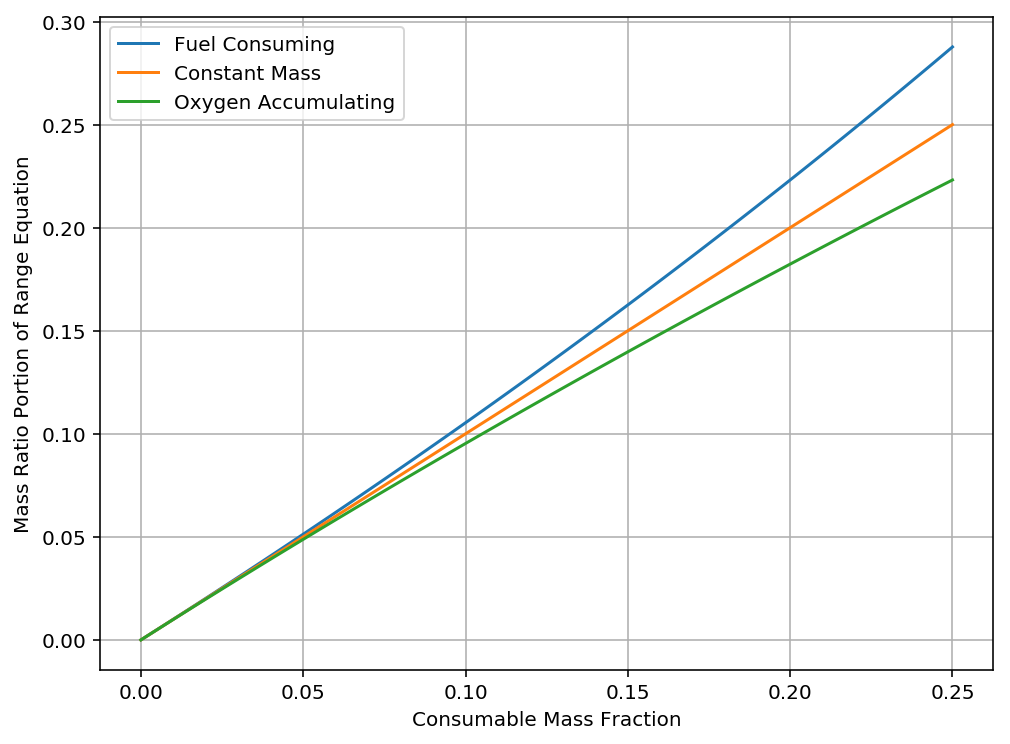

In [21]:
"""Compare the ranges of the three types of aircraft: fuel consuming, constant mass & oxygen accumulating as function of the stored chemical to
aircraft mass ratio."""

μ_stored = np.linspace(0,0.25,100)

# Range
R_fc = lambda μ: -np.log(1-μ)
R_cm = lambda μ: μ
R_oa = lambda μ: np.log(1+μ)

plt.figure(figsize=(8,6))
plt.plot(μ_stored,[R_fc(μ_s) for μ_s in μ_stored], label='Fuel Consuming')
plt.plot(μ_stored,[R_cm(μ_s) for μ_s in μ_stored], label='Constant Mass')
plt.plot(μ_stored,[R_oa(μ_s) for μ_s in μ_stored], label='Oxygen Accumulating')
plt.xlabel('Consumable Mass Fraction')
plt.ylabel('Mass Ratio Portion of Range Equation')
plt.legend()
plt.grid()
plt.show()

In [0]:
class Aircraft:
    """Aircraft class for data storage and estimation of flight performance characteristics"""
    
    def __init__(self,Type, AircraftData, Fuel=Fuel()):
        """Initialize the class by extracting performance data of interest for the aircraft specified by
        Type from AircraftData"""
        
        if Type not in AircraftData.keys():
            raise("Invalid aircraft type valid types include: {}".format(AircraftData.keys()))
            
        self.Type = Type
        self.Data = AircraftData
        self.CruiseMach = AircraftData[Type]['Cruise Mach']
        self.CruiseSpeed = AircraftData[Type]['Cruise Speed']
        self.Weight = AircraftData[Type]['Weight']
        self.WingArea = AircraftData[Type]['Wing Area']
        self.FuelCapacity = AircraftData[Type]['Fuel Capacity']
        self.Range = AircraftData[Type]['Range']
        self.Engines = AircraftData[Type]['Engines']
        self.Fuel = Fuel
    
    @property
    def EngineOverallEfficiency(self):
        return unit2SI(self.CruiseSpeed)/unit2SI(self.Engines['TSFC'])/unit2SI(self.Fuel.LHV)
    
    @property
    def Isp(self):
        """Calculate the specific impulse in seconds"""
        
        if self.Engines['TSFC'][1] == 'g/kN/s':
            Isp = (1e6 / self.Engines['TSFC'][0] / constants.g, 's')
        else:
            Isp = None    

        return Isp
    
    @property
    def MaxPayload(self):
      return ( unit2SI(self.Weight['Max Zero Fuel']) - unit2SI(self.Weight['Operating Empty Weight']), 'kg')
    
    @property
    def FuelMass(self):
        # return ( unit2SI(self.FuelCapacity)*unit2SI(self.Fuel.density), 'kg')
        return (unit2SI(self.Weight['Max Take Off']) - 
                unit2SI(self.Weight['Operating Empty Weight']) -
                unit2SI(self.MaxPayload), 'kg')
    
    @property 
    def PropulsionMass(self):
      return (self.Engines.Number * unit2SI(self.Engines.Weight), 'kg')
      
    @propety
    def AircraftMass(self):
      return 
    
    def Lift2Drag(self, Fuel_TakeOff_MassRatio=None):
        """Estimate the aircraft lift to drag ratio from the available range 
        & weight performance data"""
        
        if Fuel_TakeOff_MassRatio is None:
            # Estimate of final aircraft weight (Max Take Off - Fuel) using the nominal fuel capacity
            FinalWeight = ( unit2SI(self.Weight['Max Take Off']) - unit2SI(self.FuelMass), 'kg' )
        else:
            # Calculate the final aircraft weight(s) at the specified fuel to take-off mass ratios
            FinalWeight = ( unit2SI(self.Weight['Max Take Off']) * ( 1 - Fuel_TakeOff_MassRatio), 'kg')
                    
        return unit2SI(self.Range) / unit2SI(self.CruiseSpeed) / unit2SI(self.Isp) / np.log(
            unit2SI(self.Weight['Max Take Off']) / unit2SI(FinalWeight))
    
    @property
    def CruiseThrust(self):
        return ( (unit2SI(self.Weight['Max Take Off']) - unit2SI(self.FuelMass)/2 ) *\
            constants.g /self.Lift2Drag() / 1000, 'kN' )
        
    @property 
    def FinalWeightEstimate(self,L_D):
        """Estimate the final weight given the lift to drag ratio """

